In [1]:
import logging
import sys

LOG_FILE = "analysis.log"

logging.basicConfig(
    level=logging.INFO,
    filename=LOG_FILE,
    filemode="w",  # Overwrite previous logs on each run
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Redirect print statements to the logger
class LoggerWriter:
    def __init__(self, level):
        self.level = level
    def write(self, message):
        if message.strip():
            self.level(message.strip())
    def flush(self):
        pass

sys.stdout = LoggerWriter(logger.info)
sys.stderr = LoggerWriter(logger.error)

print("=== Logging Setup Complete ===")


In [2]:
# Process Phase - Cell 1: Load Prepared Datasets

import os
import pandas as pd

# Define the path where the prepared datasets are stored
PREPARED_PATH = "./data/prepared/"

# Dictionary mapping dataset names to their prepared file names
files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

In [3]:
# Process Phase - Cell 2: Exploratory Data Analysis on pbj_nurse
# Check basic info, data types, and missing values

pbj_nurse = loaded_datasets['pbj_nurse']
print("=== pbj_nurse DataFrame Info ===")
print(pbj_nurse.info())

print("=== Descriptive Statistics for pbj_nurse ===")
print(pbj_nurse.describe())

# Check for missing values per column
print("=== Missing Values in pbj_nurse ===")
print(pbj_nurse.isnull().sum())


In [4]:
# Process Phase - Cell 3: Time-Series Analysis Preparation
# Ensure the 'workdate' column is in datetime format

if not pd.api.types.is_datetime64_any_dtype(pbj_nurse['workdate']):
    pbj_nurse['workdate'] = pd.to_datetime(pbj_nurse['workdate'], errors='coerce')
    print("Converted 'workdate' to datetime.")
else:
    print("'workdate' is already in datetime format.")

# Set 'workdate' as the DataFrame index (optional, for time series operations)
pbj_nurse.set_index('workdate', inplace=True)

# Sample daily aggregation for RN staffing ratios
# Calculate daily total employee and contract RN hours
daily_rn = pbj_nurse.groupby(pbj_nurse.index.date).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum'
}).rename_axis('date').reset_index()

# Calculate the RN temporary staffing ratio (avoid division by zero)
daily_rn['rn_temp_ratio'] = daily_rn.apply(
    lambda row: row['hrs_rn_ctr'] / (row['hrs_rn_emp'] + row['hrs_rn_ctr'] + 1e-6), axis=1
)
print("=== Daily Aggregated RN Staffing ===")
print(daily_rn.head())


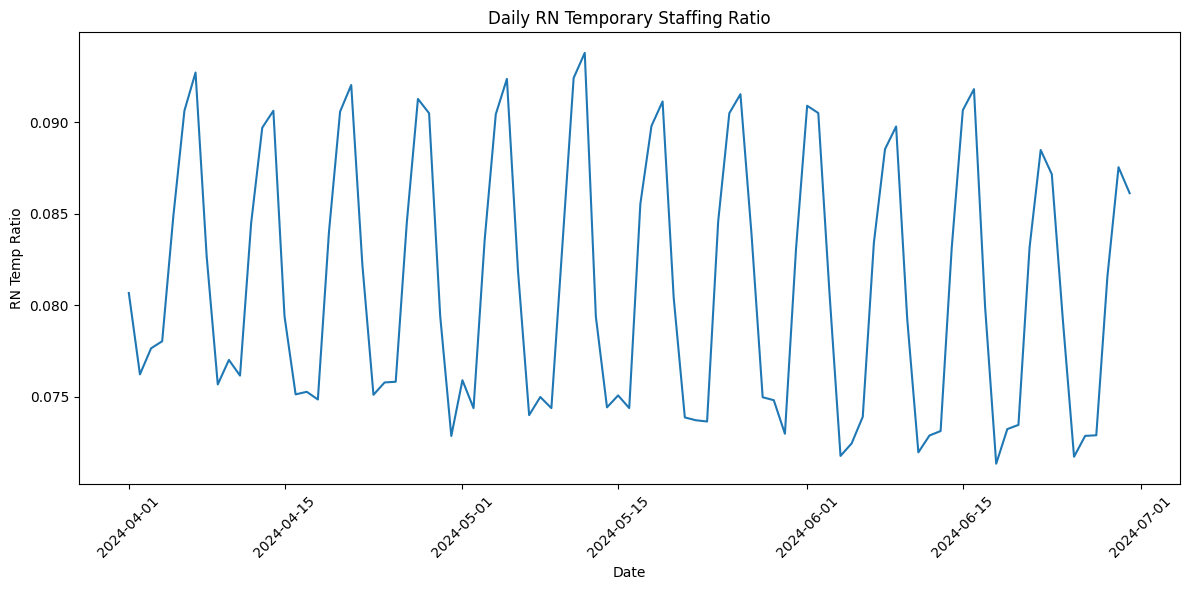

In [5]:
# Process Phase - Cell 4: Visualize Time-Series Trends for RN Temporary Staffing Ratio
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='rn_temp_ratio', data=daily_rn)
plt.title('Daily RN Temporary Staffing Ratio')
plt.xlabel('Date')
plt.ylabel('RN Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


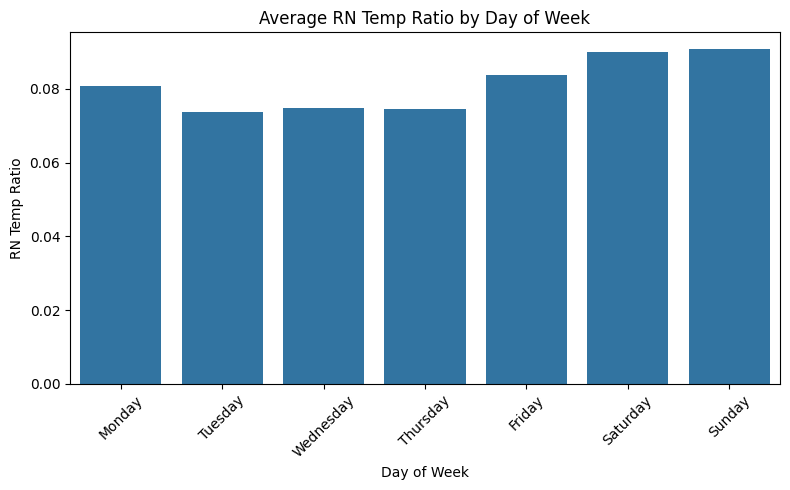

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a day_of_week column
daily_rn['date'] = pd.to_datetime(daily_rn['date'])
daily_rn['day_of_week'] = daily_rn['date'].dt.day_name()

# Group by day_of_week and compute average ratio
dow_stats = daily_rn.groupby('day_of_week')['rn_temp_ratio'].mean().reset_index()

# Sort day_of_week in a typical sequence (Mon -> Sun)
dow_stats['day_of_week'] = pd.Categorical(
    dow_stats['day_of_week'],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)
dow_stats.sort_values('day_of_week', inplace=True)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='rn_temp_ratio', data=dow_stats)
plt.title('Average RN Temp Ratio by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('RN Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


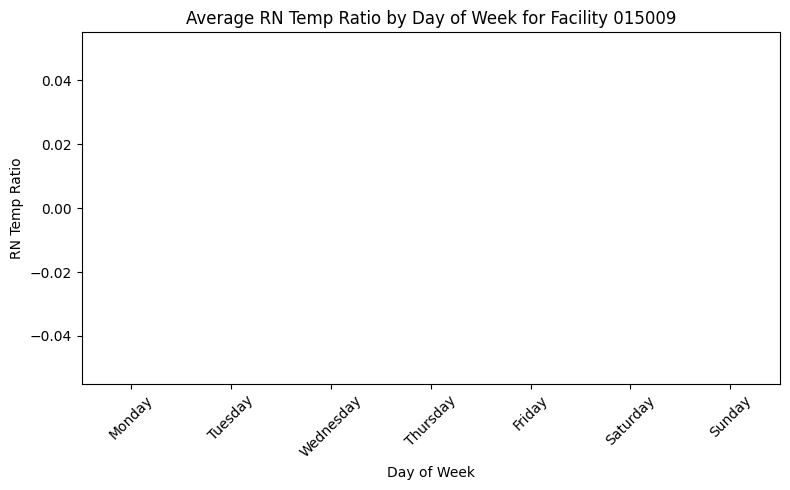

In [7]:
# Next Steps - 1: Facility-Level Exploration (Revised)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure 'workdate' is a column (if you previously set it as index)
if pbj_nurse.index.name == 'workdate':
    pbj_nurse.reset_index(inplace=True)

# 2. Create a new column 'date' from the 'workdate' column (as date objects)
pbj_nurse['date'] = pbj_nurse['workdate'].dt.date

# 3. Group by facility and the new 'date' column
facility_daily_rn = pbj_nurse.groupby(['provnum', 'date'], as_index=False).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum'
})

# 4. Convert 'date' back to datetime (if needed)
facility_daily_rn['date'] = pd.to_datetime(facility_daily_rn['date'])

# 5. Calculate RN temporary staffing ratio
facility_daily_rn['rn_temp_ratio'] = facility_daily_rn.apply(
    lambda row: row['hrs_rn_ctr'] / (row['hrs_rn_emp'] + row['hrs_rn_ctr'] + 1e-6),
    axis=1
)

# 6. Create 'day_of_week' column
facility_daily_rn['day_of_week'] = facility_daily_rn['date'].dt.day_name()

# 7. Group by facility and day_of_week to get average ratio
fac_dow_stats = facility_daily_rn.groupby(['provnum', 'day_of_week'])['rn_temp_ratio'].mean().reset_index()

# 8. Pick a sample facility to visualize
sample_facility = fac_dow_stats['provnum'].unique()[0]
fac_sample = fac_dow_stats[fac_dow_stats['provnum'] == sample_facility]

# 9. Plot
plt.figure(figsize=(8,5))
sns.barplot(
    x='day_of_week',
    y='rn_temp_ratio',
    data=fac_sample,
    order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.title(f'Average RN Temp Ratio by Day of Week for Facility {sample_facility}')
plt.xlabel('Day of Week')
plt.ylabel('RN Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


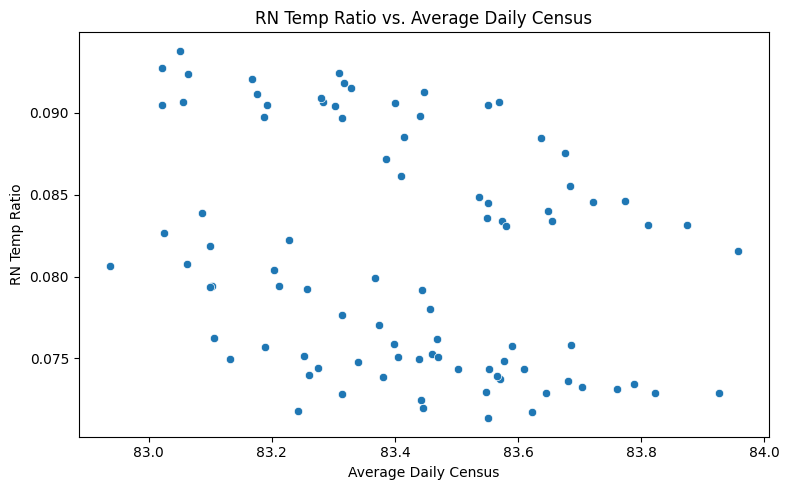

In [8]:
# Next Steps - 2: Correlation with Resident Census

import numpy as np

# 1. Aggregate daily census using workdate from pbj_nurse
daily_census = pbj_nurse.groupby(pbj_nurse['workdate'].dt.date)['mdscensus'].mean().reset_index()
daily_census.columns = ['date', 'avg_census']

# 2. Convert the 'date' column in daily_census to datetime so it matches daily_rn
daily_census['date'] = pd.to_datetime(daily_census['date'])

# 3. Merge with the daily_rn DataFrame (which already has 'date' as datetime)
merged_rn_census = pd.merge(daily_rn, daily_census, on='date', how='left')

# 4. Calculate correlation between RN temporary staffing ratio and average daily census
corr_value = merged_rn_census['rn_temp_ratio'].corr(merged_rn_census['avg_census'])
print(f"Correlation between RN Temp Ratio and Average Daily Census: {corr_value:.4f}")

# 5. Create a scatter plot to visualize the relationship
plt.figure(figsize=(8,5))
sns.scatterplot(x='avg_census', y='rn_temp_ratio', data=merged_rn_census)
plt.title('RN Temp Ratio vs. Average Daily Census')
plt.xlabel('Average Daily Census')
plt.ylabel('RN Temp Ratio')
plt.tight_layout()
plt.show()


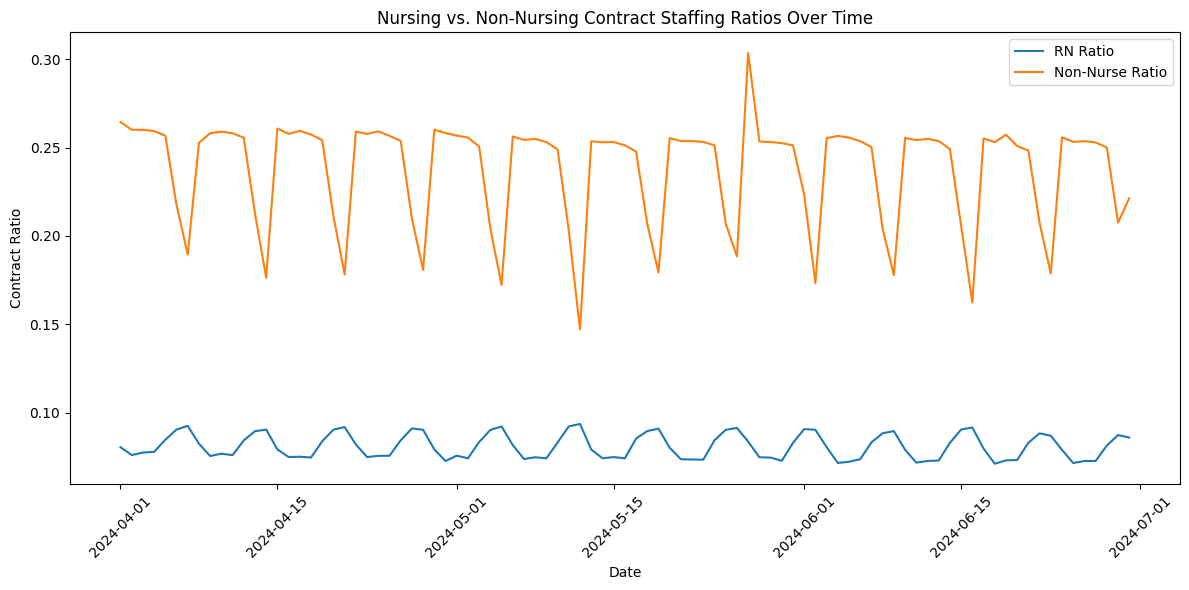

In [9]:
# Next Steps - 4: Compare Nursing vs. Non-Nursing

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Aggregate daily non-nursing contract hours
pbj_non_nurse = loaded_datasets['pbj_non_nurse'].copy()
pbj_non_nurse['workdate'] = pd.to_datetime(pbj_non_nurse['workdate'], errors='coerce')

# Group by the date part of workdate and sum all non-nursing employee & contract hours
daily_non_nurse = pbj_non_nurse.groupby(pbj_non_nurse['workdate'].dt.date).agg({
    col: 'sum' for col in pbj_non_nurse.columns if '_emp' in col or '_ctr' in col
}).reset_index()

# Rename the grouping column (which is the first column) to 'date'
daily_non_nurse.rename(columns={daily_non_nurse.columns[0]: 'date'}, inplace=True)

# 2. Sum total contract vs. employee hours across all non-nursing roles
contract_cols = [c for c in daily_non_nurse.columns if c.endswith('_ctr')]
employee_cols = [c for c in daily_non_nurse.columns if c.endswith('_emp')]

daily_non_nurse['non_nurse_emp'] = daily_non_nurse[employee_cols].sum(axis=1)
daily_non_nurse['non_nurse_ctr'] = daily_non_nurse[contract_cols].sum(axis=1)
daily_non_nurse['non_nurse_ratio'] = daily_non_nurse['non_nurse_ctr'] / (
    daily_non_nurse['non_nurse_emp'] + daily_non_nurse['non_nurse_ctr'] + 1e-6
)

# 3. Convert the 'date' column to datetime so that it matches the type in daily_rn
daily_non_nurse['date'] = pd.to_datetime(daily_non_nurse['date'])

# 4. Merge with daily_rn (which already has a datetime 'date' column)
compare_df = pd.merge(daily_rn[['date', 'rn_temp_ratio']], 
                      daily_non_nurse[['date', 'non_nurse_ratio']],
                      on='date', how='inner')

# 5. Plot both ratios over time
plt.figure(figsize=(12,6))
plt.plot(compare_df['date'], compare_df['rn_temp_ratio'], label='RN Ratio')
plt.plot(compare_df['date'], compare_df['non_nurse_ratio'], label='Non-Nurse Ratio')
plt.title('Nursing vs. Non-Nursing Contract Staffing Ratios Over Time')
plt.xlabel('Date')
plt.ylabel('Contract Ratio')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Next Steps - 5: Shift-Level Analysis (Revised)

# Check if a 'shift' column exists in pbj_nurse
if 'shift' in pbj_nurse.columns:
    # Create a new 'date' column from workdate if it doesn't exist
    if 'date' not in pbj_nurse.columns:
        pbj_nurse['date'] = pd.to_datetime(pbj_nurse['workdate']).dt.date
    # Convert 'date' column to datetime for consistent analysis
    pbj_nurse['date'] = pd.to_datetime(pbj_nurse['date'])
    
    # Group by date and shift to aggregate RN employee and contract hours
    shift_analysis = pbj_nurse.groupby(['date', 'shift']).agg({
        'hrs_rn_emp': 'sum',
        'hrs_rn_ctr': 'sum'
    }).reset_index()
    
    # Calculate the RN temporary staffing ratio for each group
    shift_analysis['rn_temp_ratio'] = shift_analysis.apply(
        lambda row: row['hrs_rn_ctr'] / (row['hrs_rn_emp'] + row['hrs_rn_ctr'] + 1e-6), axis=1
    )
    
    # For example, select a sample day to visualize shift-level differences
    sample_day = shift_analysis['date'].unique()[0]
    single_day = shift_analysis[shift_analysis['date'] == sample_day]
    
    plt.figure(figsize=(6,4))
    sns.barplot(x='shift', y='rn_temp_ratio', data=single_day)
    plt.title(f'RN Temp Ratio by Shift on {sample_day.date()}')
    plt.xlabel('Shift')
    plt.ylabel('RN Temp Ratio')
    plt.tight_layout()
    plt.show()
else:
    print("Shift-level data not available in pbj_nurse. Skipping shift-level analysis.")


In [11]:
# Next Steps - 6: Quality/Compliance Integration (Revised)

# 1. Facility-level aggregation for RN staffing from pbj_nurse
facility_rn = pbj_nurse.groupby('provnum', as_index=False).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum'
})
facility_rn['rn_temp_ratio'] = facility_rn.apply(
    lambda row: row['hrs_rn_ctr'] / (row['hrs_rn_emp'] + row['hrs_rn_ctr'] + 1e-6), axis=1
)

# 2. Ensure the quality dataset key is compatible:
qrp_provider = loaded_datasets['qrp_provider'].copy()
qrp_provider.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)

# Convert provider IDs to strings in both DataFrames for a reliable merge
qrp_provider['provnum'] = qrp_provider['provnum'].astype(str)
facility_rn['provnum'] = facility_rn['provnum'].astype(str)

# 3. Merge facility-level RN ratios with quality reporting data
merged_quality = pd.merge(facility_rn, qrp_provider, on='provnum', how='left')

# 4. Example: If there's a numeric quality score, calculate correlation
if 'score' in merged_quality.columns:
    merged_quality['score'] = pd.to_numeric(merged_quality['score'], errors='coerce')
    corr_value = merged_quality['rn_temp_ratio'].corr(merged_quality['score'])
    print(f"Correlation between RN Temp Ratio and QRP Score: {corr_value:.4f}")
else:
    print("No numeric 'score' column found in qrp_provider for correlation.")


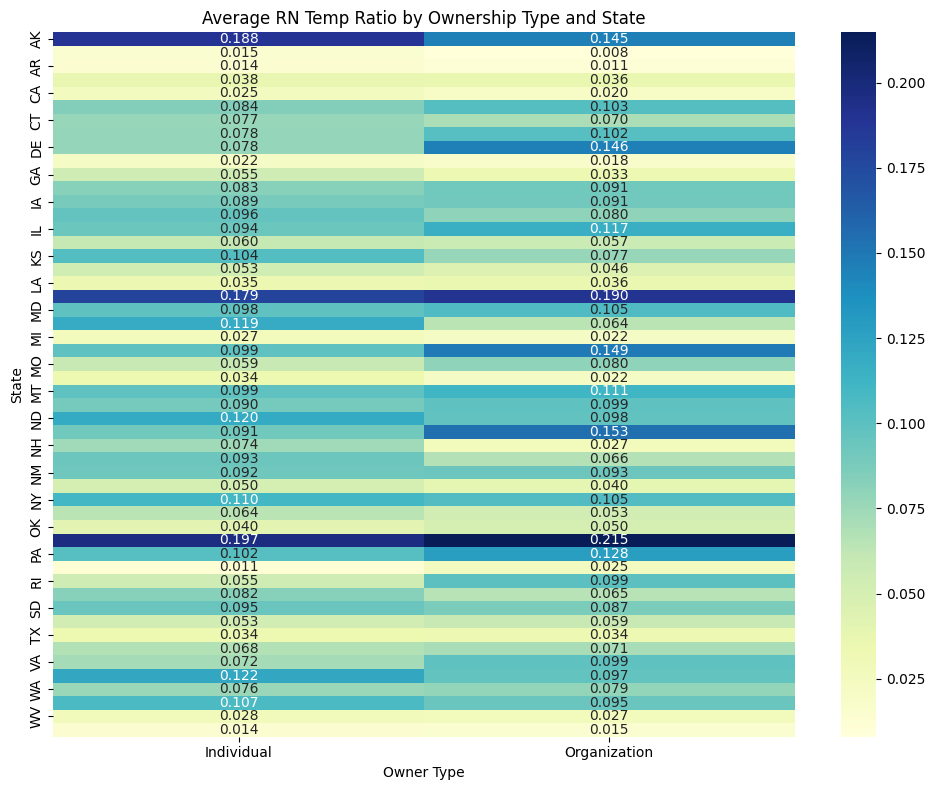

In [12]:
# Next Steps - 7: Ownership and Geographic Patterns (Revised)

# 1. Merge facility-level RN ratio with ownership data
nh_ownership = loaded_datasets['nh_ownership'].copy()
nh_ownership.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)

# Convert the key columns to string to avoid type mismatch
nh_ownership['provnum'] = nh_ownership['provnum'].astype(str)
facility_rn['provnum'] = facility_rn['provnum'].astype(str)

facility_rn_geo = pd.merge(facility_rn, nh_ownership, on='provnum', how='left')

# 2. Group by ownership type and state to calculate the average RN temporary staffing ratio
group_cols = ['owner_type', 'state']
geo_stats = facility_rn_geo.groupby(group_cols)['rn_temp_ratio'].mean().reset_index()

# 3. Create a pivot table for visualization
pivot_geo = geo_stats.pivot(index='state', columns='owner_type', values='rn_temp_ratio')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_geo, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Average RN Temp Ratio by Ownership Type and State')
plt.xlabel('Owner Type')
plt.ylabel('State')
plt.tight_layout()
plt.show()


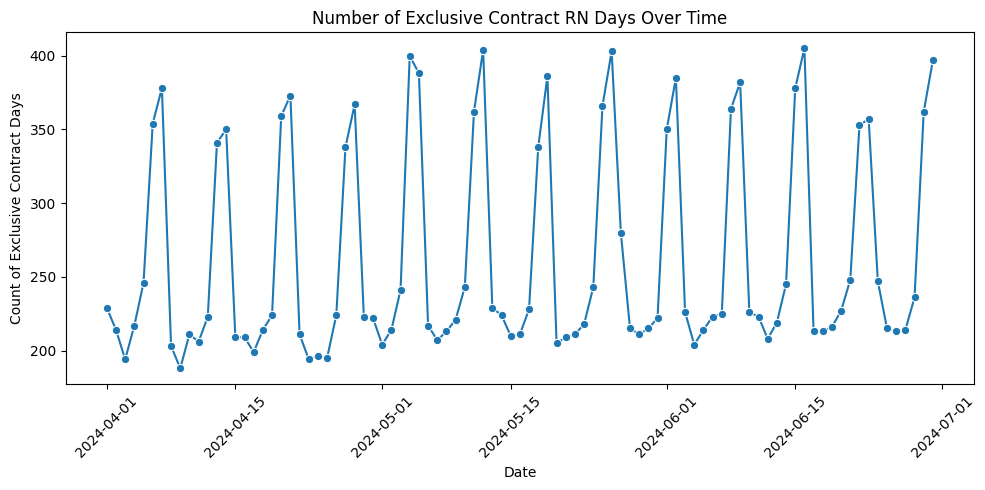

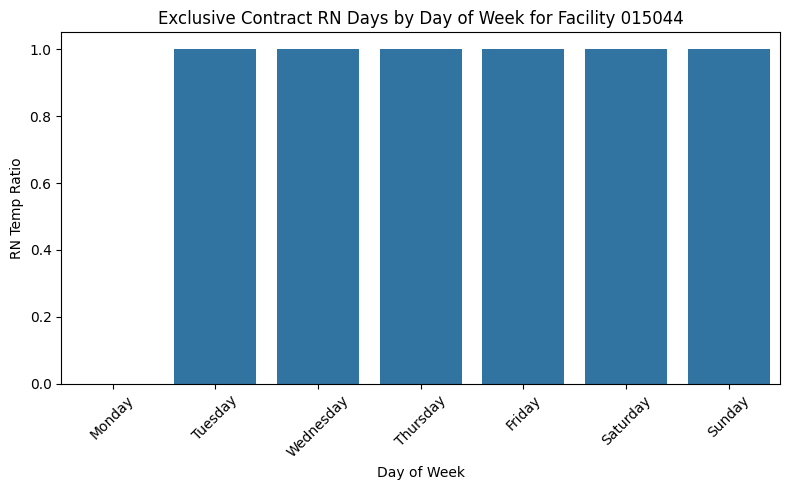

In [13]:
# Next Steps - 8: Exclusive Contract Facilities & Exclusive RN Days
# Filter for days with near-100% contract RN usage (e.g., rn_temp_ratio > 0.95)

# Use the facility_daily_rn DataFrame (from facility-level exploration)
exclusive_contract = facility_daily_rn[facility_daily_rn['rn_temp_ratio'] > 0.95]

print("Number of records with near-100% RN contract usage:", exclusive_contract.shape[0])
print("Unique facilities with exclusive contract days:", exclusive_contract['provnum'].nunique())

# Visualize the frequency of exclusive contract days over time (aggregate by date)
exclusive_by_date = exclusive_contract.groupby('date').size().reset_index(name='count')

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='count', data=exclusive_by_date, marker='o')
plt.title('Number of Exclusive Contract RN Days Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Exclusive Contract Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, visualize for a specific facility if desired
sample_exclusive_fac = exclusive_contract['provnum'].unique()[0]
exclusive_sample = exclusive_contract[exclusive_contract['provnum'] == sample_exclusive_fac]

plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='rn_temp_ratio', data=exclusive_sample,
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title(f'Exclusive Contract RN Days by Day of Week for Facility {sample_exclusive_fac}')
plt.xlabel('Day of Week')
plt.ylabel('RN Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


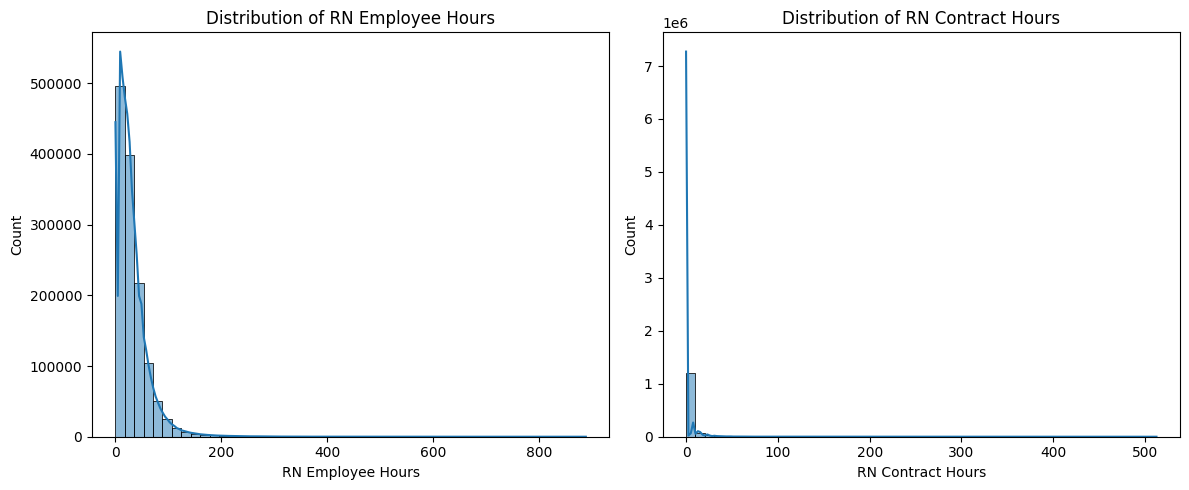

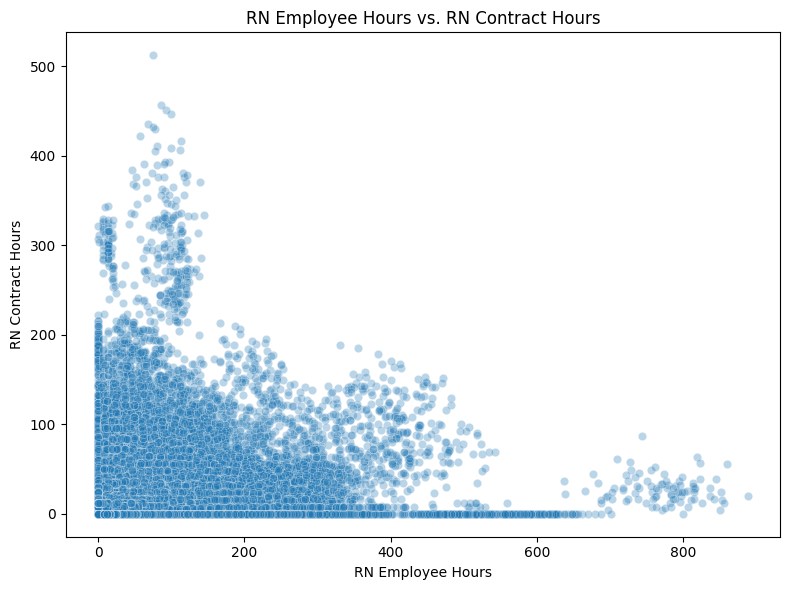

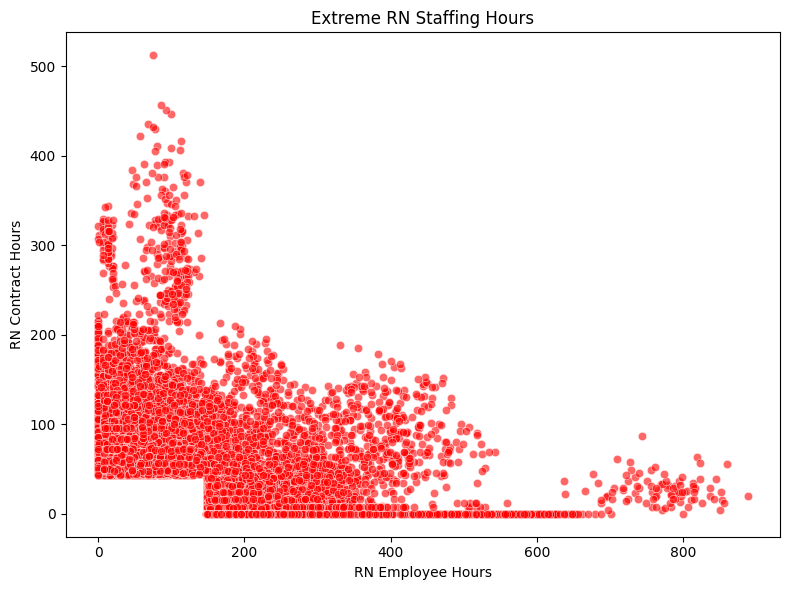

In [14]:
# Next Steps - 9: Employee vs. Contract Tails Relationship

# Let's examine the distribution of RN employee hours and contract hours,
# and also explore their relationship for extreme values.

# Histograms for hrs_rn_emp and hrs_rn_ctr in the pbj_nurse dataset
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(pbj_nurse['hrs_rn_emp'], bins=50, kde=True)
plt.title('Distribution of RN Employee Hours')
plt.xlabel('RN Employee Hours')

plt.subplot(1, 2, 2)
sns.histplot(pbj_nurse['hrs_rn_ctr'], bins=50, kde=True)
plt.title('Distribution of RN Contract Hours')
plt.xlabel('RN Contract Hours')

plt.tight_layout()
plt.show()

# Scatter plot to see the relationship between employee and contract hours
plt.figure(figsize=(8,6))
sns.scatterplot(x='hrs_rn_emp', y='hrs_rn_ctr', data=pbj_nurse, alpha=0.3)
plt.title('RN Employee Hours vs. RN Contract Hours')
plt.xlabel('RN Employee Hours')
plt.ylabel('RN Contract Hours')
plt.tight_layout()
plt.show()

# Optionally, focus on extreme values (e.g., top 1% for each metric)
threshold_emp = pbj_nurse['hrs_rn_emp'].quantile(0.99)
threshold_ctr = pbj_nurse['hrs_rn_ctr'].quantile(0.99)

extreme_data = pbj_nurse[(pbj_nurse['hrs_rn_emp'] > threshold_emp) | 
                          (pbj_nurse['hrs_rn_ctr'] > threshold_ctr)]

plt.figure(figsize=(8,6))
sns.scatterplot(x='hrs_rn_emp', y='hrs_rn_ctr', data=extreme_data, color='red', alpha=0.6)
plt.title('Extreme RN Staffing Hours')
plt.xlabel('RN Employee Hours')
plt.ylabel('RN Contract Hours')
plt.tight_layout()
plt.show()


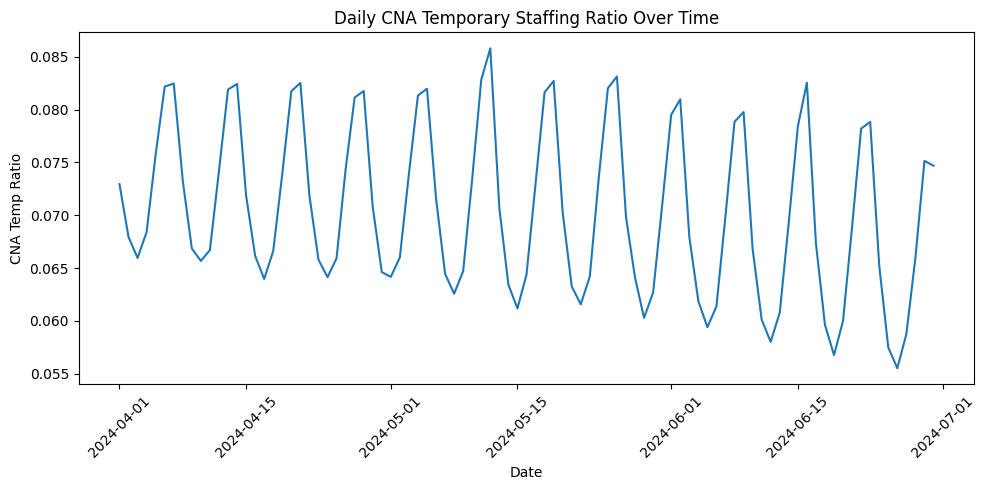

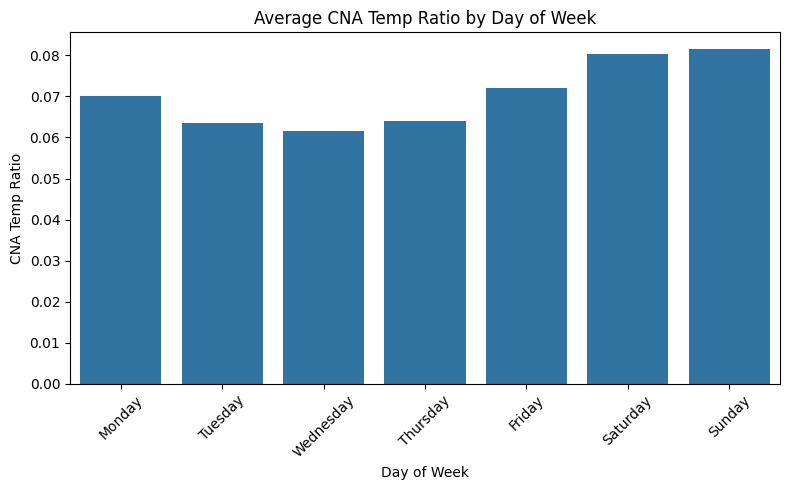

In [15]:
# Next Steps: CNA Oscillation Patterns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Work on a copy of pbj_nurse from loaded_datasets
pbj_nurse_copy = loaded_datasets['pbj_nurse'].copy()
if pbj_nurse_copy.index.name == 'workdate':
    pbj_nurse_copy.reset_index(inplace=True)

# Ensure 'workdate' is datetime
pbj_nurse_copy['workdate'] = pd.to_datetime(pbj_nurse_copy['workdate'], errors='coerce')

# Create a new column 'date' from 'workdate'
pbj_nurse_copy['date'] = pbj_nurse_copy['workdate'].dt.date

# Debug: Print the column names in pbj_nurse_copy to verify 'hrs_cna_emp' and 'hrs_cna_ctr' exist
print("Columns in pbj_nurse_copy:", pbj_nurse_copy.columns.tolist())

# Group by 'date' and aggregate CNA employee, CNA contract hours, and average census
daily_cna = pbj_nurse_copy.groupby('date', as_index=False).agg({
    'hrs_cna_emp': 'sum',
    'hrs_cna_ctr': 'sum',
    'mdscensus': 'mean'
})

# Convert the 'date' column to datetime for further processing
daily_cna['date'] = pd.to_datetime(daily_cna['date'])

# Debug: Print columns in daily_cna
print("Columns in daily_cna:", daily_cna.columns.tolist())

# Check that the required CNA columns exist
if 'hrs_cna_emp' not in daily_cna.columns or 'hrs_cna_ctr' not in daily_cna.columns:
    raise KeyError("Expected columns 'hrs_cna_emp' and/or 'hrs_cna_ctr' not found in daily_cna. Columns found: " + str(daily_cna.columns.tolist()))
else:
    # Calculate CNA temporary staffing ratio
    daily_cna['cna_temp_ratio'] = daily_cna.apply(
        lambda row: row['hrs_cna_ctr'] / (row['hrs_cna_emp'] + row['hrs_cna_ctr'] + 1e-6),
        axis=1
    )

# 5. Correlation with resident census
corr_cna_census = daily_cna['cna_temp_ratio'].corr(daily_cna['mdscensus'])
print(f"CNA Ratio vs. Census correlation: {corr_cna_census:.4f}")

# 6. Plot time-series of CNA ratio
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='cna_temp_ratio', data=daily_cna)
plt.title('Daily CNA Temporary Staffing Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('CNA Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Day-of-week breakdown for CNA ratio
daily_cna['day_of_week'] = daily_cna['date'].dt.day_name()
dow_cna = daily_cna.groupby('day_of_week')['cna_temp_ratio'].mean().reset_index()

# Sort day_of_week in typical sequence
dow_cna['day_of_week'] = pd.Categorical(
    dow_cna['day_of_week'],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)
dow_cna.sort_values('day_of_week', inplace=True)

# 8. Bar plot for day-of-week
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='cna_temp_ratio', data=dow_cna)
plt.title('Average CNA Temp Ratio by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('CNA Temp Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


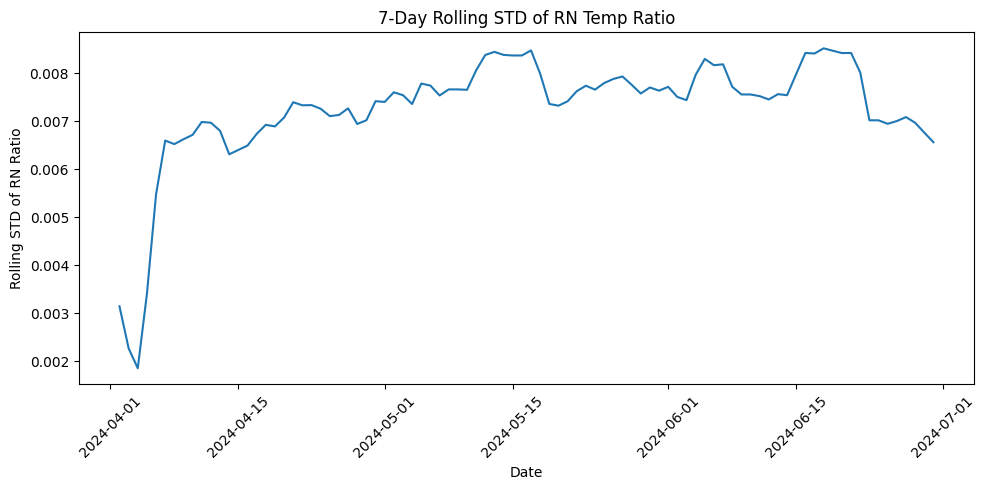

In [16]:
# Next Steps: Intra-Quarter Inconsistencies & Variability Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use the previously computed daily_rn DataFrame (from Time-Series Analysis Preparation)
# Ensure 'date' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(daily_rn['date']):
    daily_rn['date'] = pd.to_datetime(daily_rn['date'])

daily_rn_var = daily_rn.copy()
daily_rn_var.sort_values('date', inplace=True)

# 2. Calculate a rolling standard deviation (7-day window) for the RN temporary staffing ratio
rolling_window = 7
daily_rn_var['rn_ratio_rolling_std'] = (
    daily_rn_var['rn_temp_ratio']
    .rolling(window=rolling_window, min_periods=1)
    .std()
)

# 3. Plot the rolling standard deviation over time
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='rn_ratio_rolling_std', data=daily_rn_var)
plt.title(f'{rolling_window}-Day Rolling STD of RN Temp Ratio')
plt.xlabel('Date')
plt.ylabel('Rolling STD of RN Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Identify days/weeks with higher-than-average variability
std_threshold = daily_rn_var['rn_ratio_rolling_std'].mean() + daily_rn_var['rn_ratio_rolling_std'].std()
high_variability = daily_rn_var[daily_rn_var['rn_ratio_rolling_std'] > std_threshold]

print("Days with high RN ratio variability:")
print(high_variability[['date', 'rn_temp_ratio', 'rn_ratio_rolling_std']].head(10))

# 5. (Optional) Facility-level analysis: Using facility_daily_rn from Facility-Level Exploration
if 'date' not in facility_daily_rn.columns:
    raise KeyError("The 'date' column is missing from facility_daily_rn. Please ensure it is computed as in the Facility-Level Exploration cell.")

facility_var = facility_daily_rn.copy()
facility_var.sort_values(['provnum', 'date'], inplace=True)

# Define a function to compute a rolling std per facility
def rolling_std_by_facility(df):
    df = df.sort_values('date')
    df['rn_ratio_rolling_std'] = df['rn_temp_ratio'].rolling(window=7, min_periods=1).std()
    return df

facility_var = facility_var.groupby('provnum', group_keys=False).apply(rolling_std_by_facility)

# Identify facility-level days with high variability
mean_std = facility_var['rn_ratio_rolling_std'].mean()
std_std = facility_var['rn_ratio_rolling_std'].std()
threshold_fac = mean_std + std_std

outlier_variability = facility_var[facility_var['rn_ratio_rolling_std'] > threshold_fac]
print("Facility-level days with high variability in RN ratio:")
print(outlier_variability[['provnum', 'date', 'rn_temp_ratio', 'rn_ratio_rolling_std']].head(10))


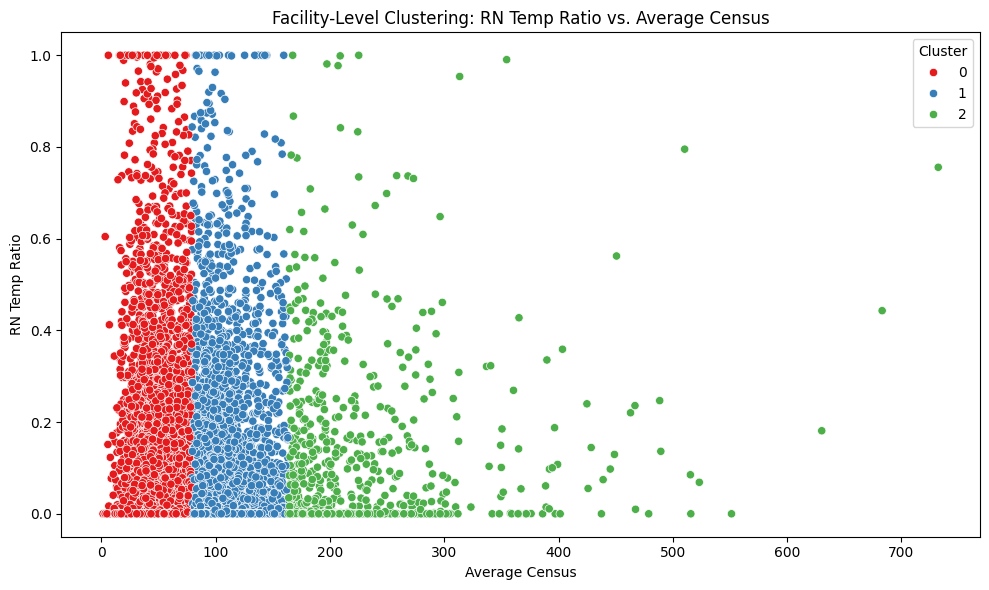

In [17]:
# Next Steps - 13: Facility-Level Clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Compute facility-level average census from pbj_nurse
facility_census = pbj_nurse.groupby('provnum', as_index=False).agg({
    'mdscensus': 'mean'
})
facility_census['provnum'] = facility_census['provnum'].astype(str)

# Ensure facility_rn (from earlier) is available and has 'provnum' as string
facility_rn = pbj_nurse.groupby('provnum', as_index=False).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum'
})
facility_rn['rn_temp_ratio'] = facility_rn.apply(
    lambda row: row['hrs_rn_ctr'] / (row['hrs_rn_emp'] + row['hrs_rn_ctr'] + 1e-6), axis=1
)
facility_rn['provnum'] = facility_rn['provnum'].astype(str)

# Merge facility-level RN ratio with average census
facility_cluster = pd.merge(facility_rn, facility_census, on='provnum', how='left')

# Use features: rn_temp_ratio and mdscensus (fill missing with 0)
features = facility_cluster[['rn_temp_ratio', 'mdscensus']].fillna(0)

# Apply KMeans clustering (e.g., into 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
facility_cluster['cluster'] = kmeans.fit_predict(features)

# Visualize the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='mdscensus', y='rn_temp_ratio', hue='cluster', data=facility_cluster, palette='Set1')
plt.title('Facility-Level Clustering: RN Temp Ratio vs. Average Census')
plt.xlabel('Average Census')
plt.ylabel('RN Temp Ratio')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Optional: Print cluster statistics
print("Cluster means:")
print(facility_cluster.groupby('cluster')[['rn_temp_ratio', 'mdscensus']].mean())


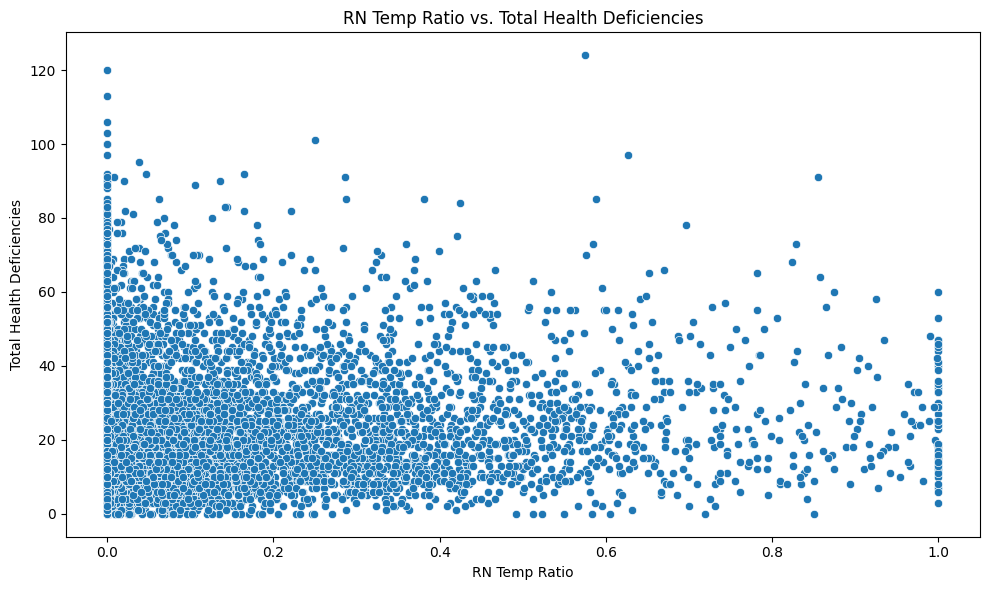

In [18]:
# Next Steps - 14: Deficiency Analysis

# Work with the nh_survey dataset; rename key to 'provnum' for merging
nh_survey = loaded_datasets['nh_survey'].copy()
nh_survey.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_survey['provnum'] = nh_survey['provnum'].astype(str)

# Aggregate deficiencies at the facility level (sum total health deficiencies)
facility_deficiencies = nh_survey.groupby('provnum', as_index=False).agg({
    'total_number_of_health_deficiencies': 'sum'
})

# Merge with facility_rn (which has the RN temp ratio)
facility_quality = pd.merge(facility_rn, facility_deficiencies, on='provnum', how='left')
# Fill missing deficiencies with 0
facility_quality['total_number_of_health_deficiencies'] = facility_quality['total_number_of_health_deficiencies'].fillna(0)

# Compute correlation between RN temp ratio and total health deficiencies
corr_def = facility_quality['rn_temp_ratio'].corr(facility_quality['total_number_of_health_deficiencies'])
print(f"Correlation between RN Temp Ratio and Total Health Deficiencies: {corr_def:.4f}")

# Scatter plot to visualize the relationship
plt.figure(figsize=(10,6))
sns.scatterplot(x='rn_temp_ratio', y='total_number_of_health_deficiencies', data=facility_quality)
plt.title('RN Temp Ratio vs. Total Health Deficiencies')
plt.xlabel('RN Temp Ratio')
plt.ylabel('Total Health Deficiencies')
plt.tight_layout()
plt.show()


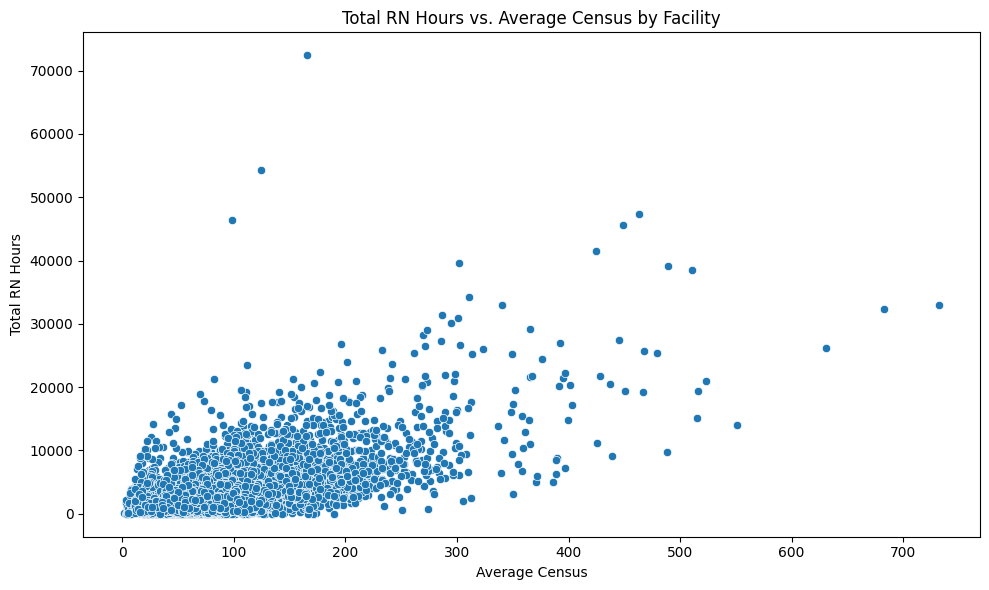

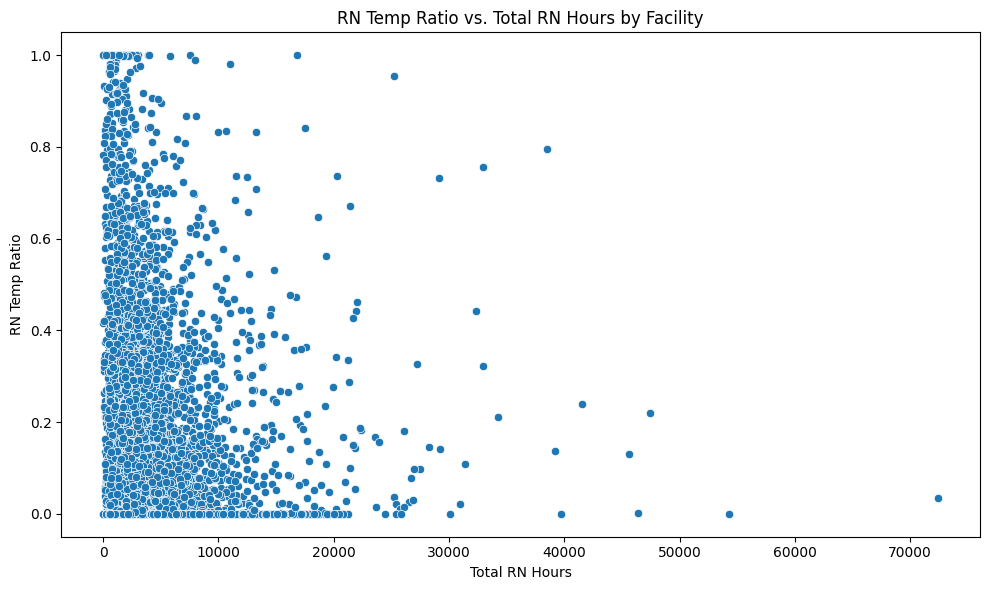

In [19]:
# Next Steps - High Staffing Facilities (Refined)
# Identify facilities with high total RN staffing hours and analyze their RN temp ratio and census

# Aggregate total RN hours (employee + contract) and average census by facility from pbj_nurse
facility_total_hours = pbj_nurse.groupby('provnum', as_index=False).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum',
    'mdscensus': 'mean'
})
facility_total_hours['total_rn_hours'] = facility_total_hours['hrs_rn_emp'] + facility_total_hours['hrs_rn_ctr']
facility_total_hours['rn_temp_ratio'] = facility_total_hours['hrs_rn_ctr'] / (facility_total_hours['total_rn_hours'] + 1e-6)

# Identify the top 10% facilities by total RN hours
threshold_total = facility_total_hours['total_rn_hours'].quantile(0.90)
high_staff_facilities = facility_total_hours[facility_total_hours['total_rn_hours'] >= threshold_total]

print("Top 10% Facilities by Total RN Hours:")
print(high_staff_facilities[['provnum', 'total_rn_hours', 'rn_temp_ratio', 'mdscensus']].describe())

# Scatter plot: Total RN Hours vs. Average Census
plt.figure(figsize=(10,6))
sns.scatterplot(x='mdscensus', y='total_rn_hours', data=facility_total_hours)
plt.title('Total RN Hours vs. Average Census by Facility')
plt.xlabel('Average Census')
plt.ylabel('Total RN Hours')
plt.tight_layout()
plt.show()

# Scatter plot: RN Temp Ratio vs. Total RN Hours
plt.figure(figsize=(10,6))
sns.scatterplot(x='total_rn_hours', y='rn_temp_ratio', data=facility_total_hours)
plt.title('RN Temp Ratio vs. Total RN Hours by Facility')
plt.xlabel('Total RN Hours')
plt.ylabel('RN Temp Ratio')
plt.tight_layout()
plt.show()


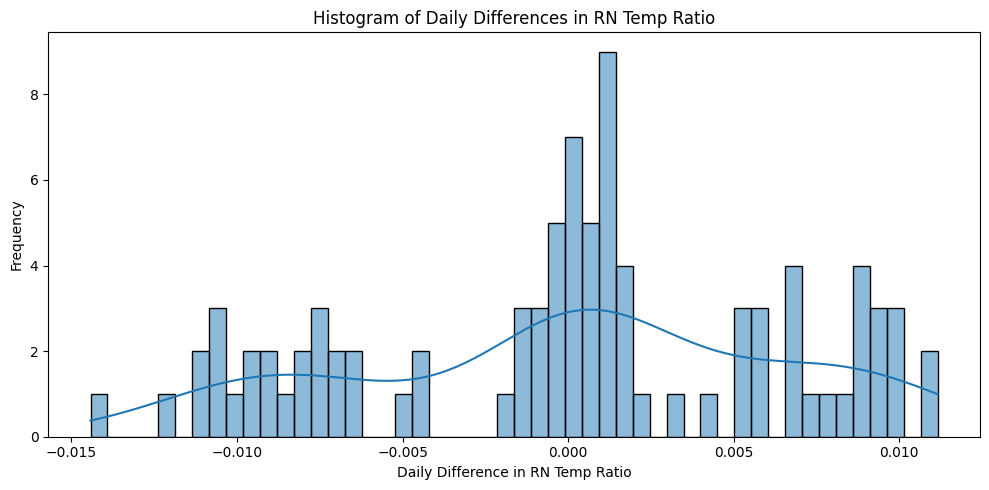

In [20]:
# Next Steps - Further Analysis on Usage Patterns
# Compute day-to-day differences in RN temp ratio using the daily_rn DataFrame

daily_rn_sorted = daily_rn.sort_values('date').copy()
daily_rn_sorted['rn_ratio_diff'] = daily_rn_sorted['rn_temp_ratio'].diff()

# Plot histogram of the daily differences
plt.figure(figsize=(10,5))
sns.histplot(daily_rn_sorted['rn_ratio_diff'].dropna(), bins=50, kde=True)
plt.title('Histogram of Daily Differences in RN Temp Ratio')
plt.xlabel('Daily Difference in RN Temp Ratio')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Print summary statistics for these differences
print("Summary statistics for daily RN temp ratio differences:")
print(daily_rn_sorted['rn_ratio_diff'].describe())


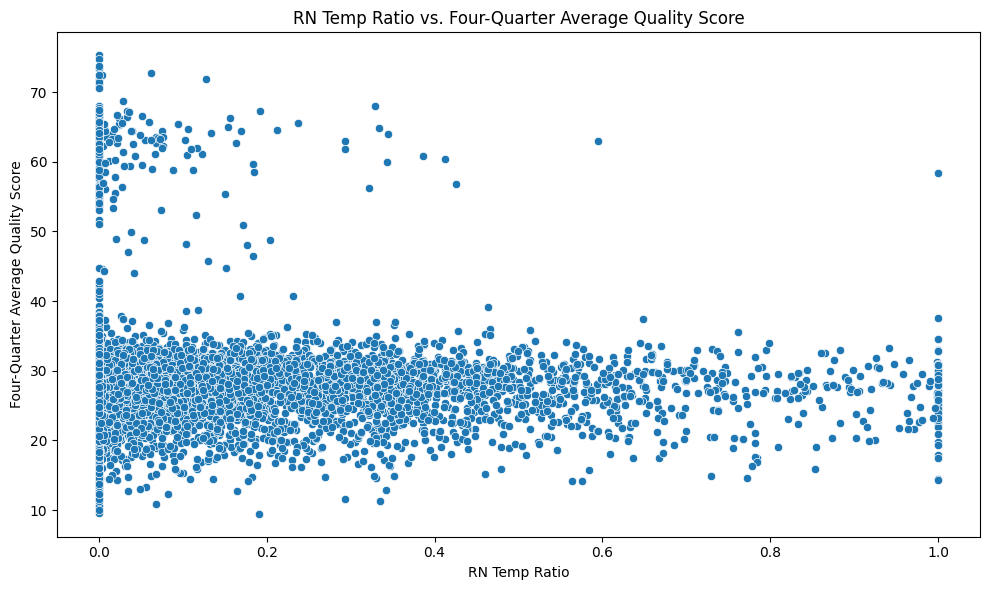

In [21]:
# Next Steps - Additional Integration with CMS Quality Measures
# Use nh_quality_mds to aggregate quality scores and merge with facility-level RN ratio data

nh_quality = loaded_datasets['nh_quality_mds'].copy()
nh_quality.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_quality['provnum'] = nh_quality['provnum'].astype(str)

# Aggregate quality scores at the facility level (using four_quarter_average_score)
facility_quality = nh_quality.groupby('provnum', as_index=False)['four_quarter_average_score'].mean()

# Merge with facility-level RN ratio (from earlier, facility_rn)
facility_quality = pd.merge(facility_rn, facility_quality, on='provnum', how='left')
facility_quality['four_quarter_average_score'] = pd.to_numeric(facility_quality['four_quarter_average_score'], errors='coerce')

# Compute correlation between RN temp ratio and quality score
corr_quality = facility_quality['rn_temp_ratio'].corr(facility_quality['four_quarter_average_score'])
print(f"Correlation between RN Temp Ratio and Four-Quarter Average Quality Score: {corr_quality:.4f}")

# Scatter plot for RN temp ratio vs. quality score
plt.figure(figsize=(10,6))
sns.scatterplot(x='rn_temp_ratio', y='four_quarter_average_score', data=facility_quality)
plt.title('RN Temp Ratio vs. Four-Quarter Average Quality Score')
plt.xlabel('RN Temp Ratio')
plt.ylabel('Four-Quarter Average Quality Score')
plt.tight_layout()
plt.show()
